You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 4. Compressed Sensing of CT Scans with Robust Regression 

## Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    Broadcasting provides a means of vectorizing array operations so that looping 
    occurs in C instead of Python. It does this without making needless copies of data 
    and usually leads to efficient algorithm implementations.

The simplest example of broadcasting occurs when multiplying an array by a scalar.

In [718]:
a = np.array([1.0, 2.0, 3.0])
b = 2.0
a * b

array([ 2.,  4.,  6.])

In [128]:
v=np.array([1,2,3])
print(v, v.shape)

[1 2 3] (3,)


In [129]:
m=np.array([v,v*2,v*3]); m, m.shape

(array([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]]), (3, 3))

In [133]:
n = np.array([m*1, m*5])

In [134]:
n

array([[[ 1,  2,  3],
        [ 2,  4,  6],
        [ 3,  6,  9]],

       [[ 5, 10, 15],
        [10, 20, 30],
        [15, 30, 45]]])

In [136]:
n.shape, m.shape

((2, 3, 3), (3, 3))

We can use broadcasting to **add** a matrix and an array:

In [48]:
m+v

array([[ 2,  4,  6],
       [ 3,  6,  9],
       [ 4,  8, 12]])

Notice what happens if we transpose the array:

In [49]:
v1=np.expand_dims(v,-1); v1, v1.shape

(array([[1],
        [2],
        [3]]), (3, 1))

In [50]:
m+v1

array([[ 2,  3,  4],
       [ 4,  6,  8],
       [ 6,  9, 12]])

#### General Numpy Broadcasting Rules

When operating on two arrays, NumPy compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

Arrays do not need to have the same number of dimensions. For example, if you have a $256 \times 256 \times 3$ array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

#### Review

In [165]:
v = np.array([1,2,3,4])
m = np.array([v,v*2,v*3])
A = np.array([5*m, -1*m])

In [166]:
v.shape, m.shape, A.shape

((4,), (3, 4), (2, 3, 4))

Will the following operations work?

In [159]:
A

array([[[ 5, 10, 15],
        [10, 20, 30],
        [15, 30, 45]],

       [[-1, -2, -3],
        [-2, -4, -6],
        [-3, -6, -9]]])

In [158]:
A + v

array([[[ 6, 12, 18],
        [11, 22, 33],
        [16, 32, 48]],

       [[ 0,  0,  0],
        [-1, -2, -3],
        [-2, -4, -6]]])

In [167]:
A

array([[[  5,  10,  15,  20],
        [ 10,  20,  30,  40],
        [ 15,  30,  45,  60]],

       [[ -1,  -2,  -3,  -4],
        [ -2,  -4,  -6,  -8],
        [ -3,  -6,  -9, -12]]])

In [168]:
A.T.shape

(4, 3, 2)

In [169]:
A.T

array([[[  5,  -1],
        [ 10,  -2],
        [ 15,  -3]],

       [[ 10,  -2],
        [ 20,  -4],
        [ 30,  -6]],

       [[ 15,  -3],
        [ 30,  -6],
        [ 45,  -9]],

       [[ 20,  -4],
        [ 40,  -8],
        [ 60, -12]]])

### Sparse Matrices (in Scipy)

A matrix with lots of zeros is called **sparse** (the opposite of sparse is **dense**).  For sparse matrices, you can save a lot of memory by only storing the non-zero values.

<img src="images/sparse.png" alt="floating point" style="width: 50%"/>

Another example of a large, sparse matrix:

<img src="images/Finite_element_sparse_matrix.png" alt="floating point" style="width: 50%"/>
[Source](https://commons.wikimedia.org/w/index.php?curid=2245335)

There are the most common sparse storage formats:
- coordinate-wise (scipy calls COO)
- compressed sparse row (CSR)
- compressed sparse column (CSC)

Let's walk through [these examples](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html)

There are actually [many more formats](http://www.cs.colostate.edu/~mcrob/toolbox/c++/sparseMatrix/sparse_matrix_compression.html) as well.

A class of matrices (e.g, diagonal) is generally called sparse if the number of non-zero elements is proportional to the number of rows (or columns) instead of being proportional to the product rows x columns.

**Scipy Implementation**

From the [Scipy Sparse Matrix Documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)

- To construct a matrix efficiently, use either dok_matrix or lil_matrix. The lil_matrix class supports basic slicing and fancy indexing with a similar syntax to NumPy arrays. As illustrated below, the COO format may also be used to efficiently construct matrices
- To perform manipulations such as multiplication or inversion, first convert the matrix to either CSC or CSR format.
- All conversions among the CSR, CSC, and COO formats are efficient, linear-time operations.

## Today: CT scans

["Can Maths really save your life? Of course it can!!"](https://plus.maths.org/content/saving-lives-mathematics-tomography) (lovely article)

<img src="images/xray.png" alt="Computed Tomography (CT)" style="width: 80%"/>

(CAT and CT scan refer to the [same procedure](http://blog.cincinnatichildrens.org/radiology/whats-the-difference-between-a-cat-scan-and-a-ct-scan/).  CT scan is the more modern term)

This lesson is based off the Scikit-Learn example [Compressive sensing: tomography reconstruction with L1 prior (Lasso)](http://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html)

#### Our goal today

Take the readings from a CT scan and construct what the original looks like.

<img src="images/lesson4.png" alt="Projections" style="width: 90%"/>

For each x-ray (at a particular position and particular angle), we get a single measurement.  We need to construct the original picture just from these measurements.  Also, we don't want the patient to experience a ton of radiation, so we are gathering less data than the area of the picture.

<img src="images/data_xray.png" alt="Projections" style=""/>

### Review

In the previous lesson, we used Robust PCA for background removal of a surveillance video.  We saw that this could be written as the optimization problem:

$$ minimize\; \lVert L \rVert_* + \lambda\lVert S \rVert_1 \\ subject\;to\; L + S = M$$

**Question**: Do you remember what is special about the L1 norm?

#### Today

We will see that:

<img src="images/sklearn_ct.png" alt="Computed Tomography (CT)" style="width: 80%"/>


Resources:
[Compressed Sensing](https://people.csail.mit.edu/indyk/princeton.pdf)

<img src="images/ct_1.png" alt="Computed Tomography (CT)" style="width: 80%"/>

[Source](https://www.fields.utoronto.ca/programs/scientific/10-11/medimaging/presentations/Plenary_Sidky.pdf)

### Imports

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, math
from scipy import ndimage, sparse

In [2]:
np.set_printoptions(suppress=True)

## Generate Data

### Intro

We will use generated data today (not real CT scans).  There is some interesting numpy and linear algebra involved in generating the data, and we will return to that later.

Code is from this Scikit-Learn example [Compressive sensing: tomography reconstruction with L1 prior (Lasso)](http://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html)

### Generate pictures

In [3]:
def generate_synthetic_data():
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2) ** 2 + (y - l / 2) ** 2 < (l / 2) ** 2
    mx,my = rs.randint(0, l, (2,n_pts))
    mask = np.zeros((l, l))
    mask[mx,my] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = (mask > mask.mean()) & mask_outer
    return res ^ ndimage.binary_erosion(res)

In [208]:
l = 128
data = generate_synthetic_data()

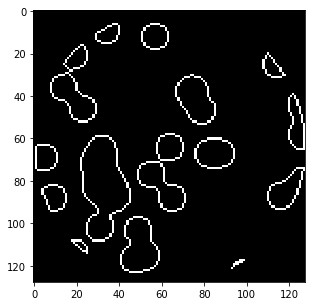

In [209]:
plt.figure(figsize=(5,5))
plt.imshow(data, cmap=plt.cm.gray);

#### What generate_synthetic_data() is doing

In [155]:
l=8; n_pts=5
rs = np.random.RandomState(0)

In [156]:
x, y = np.ogrid[0:l, 0:l]; x,y

(array([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7]]), array([[0, 1, 2, 3, 4, 5, 6, 7]]))

In [170]:
x + y

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14]])

In [157]:
(x - l/2) ** 2 

array([[ 16.],
       [  9.],
       [  4.],
       [  1.],
       [  0.],
       [  1.],
       [  4.],
       [  9.]])

In [59]:
(x - l/2) ** 2 + (y - l/2) ** 2

array([[ 32.,  25.,  20.,  17.,  16.,  17.,  20.,  25.],
       [ 25.,  18.,  13.,  10.,   9.,  10.,  13.,  18.],
       [ 20.,  13.,   8.,   5.,   4.,   5.,   8.,  13.],
       [ 17.,  10.,   5.,   2.,   1.,   2.,   5.,  10.],
       [ 16.,   9.,   4.,   1.,   0.,   1.,   4.,   9.],
       [ 17.,  10.,   5.,   2.,   1.,   2.,   5.,  10.],
       [ 20.,  13.,   8.,   5.,   4.,   5.,   8.,  13.],
       [ 25.,  18.,  13.,  10.,   9.,  10.,  13.,  18.]])

In [60]:
mask_outer = (x - l/2) ** 2 + (y - l/2) ** 2 < (l/2) ** 2; mask_outer

array([[False, False, False, False, False, False, False, False],
       [False, False,  True,  True,  True,  True,  True, False],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True, False]], dtype=bool)

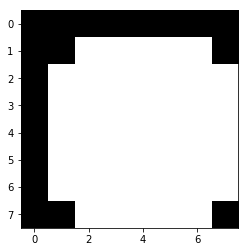

In [61]:
plt.imshow(mask_outer, cmap='gray')

In [62]:
mask = np.zeros((l, l))
mx,my = rs.randint(0, l, (2,n_pts))
mask[mx,my] = 1; mask

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

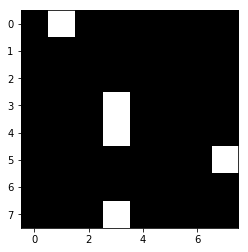

In [63]:
plt.imshow(mask, cmap='gray')

In [64]:
mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)

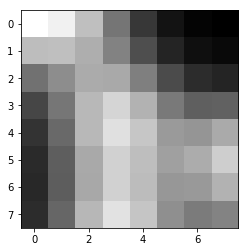

In [65]:
plt.imshow(mask, cmap='gray')

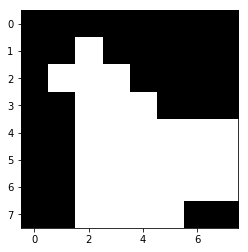

In [66]:
res = np.logical_and(mask > mask.mean(), mask_outer)
plt.imshow(res, cmap='gray');

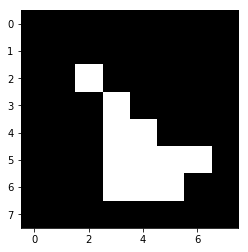

In [67]:
plt.imshow(ndimage.binary_erosion(res), cmap='gray');

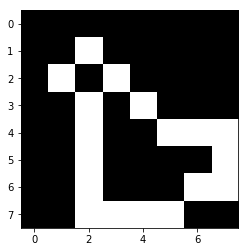

In [68]:
plt.imshow(res ^ ndimage.binary_erosion(res), cmap='gray');

### Generate Projections

#### Code

In [72]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

In [73]:
def build_projection_operator(l_x, n_dir):
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = (inds >= 0) & (inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

#### Projection operator

In [210]:
l = 128

In [211]:
proj_operator = build_projection_operator(l, l // 7)

In [212]:
proj_operator

<2304x16384 sparse matrix of type '<class 'numpy.float64'>'
	with 555378 stored elements in COOrdinate format>

dimensions: angles (l//7), positions (l), image for each (l x l)

In [213]:
proj_t = np.reshape(proj_operator.todense().A, (l//7,l,l,l))

The first coordinate refers to the angle of the line, and the second coordinate refers to the location of the line.

The lines for the angle indexed with 3:

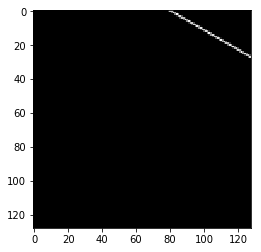

In [214]:
plt.imshow(proj_t[3,0], cmap='gray');

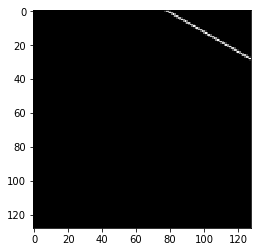

In [215]:
plt.imshow(proj_t[3,1], cmap='gray');

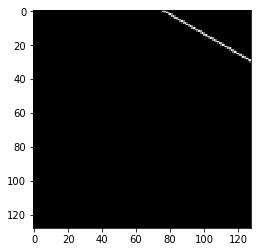

In [216]:
plt.imshow(proj_t[3,2], cmap='gray');

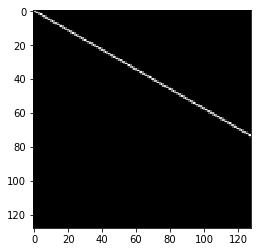

In [217]:
plt.imshow(proj_t[3,40], cmap='gray');

Other lines at vertical location 40:

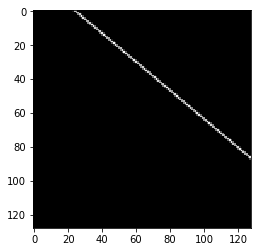

In [218]:
plt.imshow(proj_t[4,40], cmap='gray');

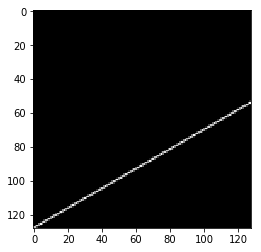

In [219]:
plt.imshow(proj_t[15,40], cmap='gray');

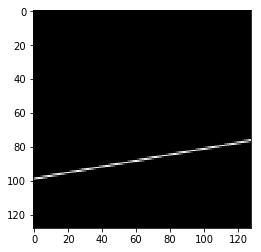

In [220]:
plt.imshow(proj_t[17,40], cmap='gray');

#### Intersection between x-rays and data

Next, we want to see how the line intersects with our data.  Remember, this is what the data looks like:

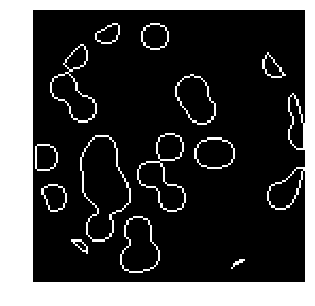

In [221]:
plt.figure(figsize=(5,5))
plt.imshow(data, cmap=plt.cm.gray)
plt.axis('off')
plt.savefig("images/data.png")

In [222]:
proj = proj_operator @ data.ravel()[:, np.newaxis]

An x-ray at angle 17, location 40 passing through the data:

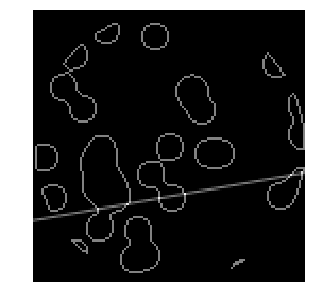

In [223]:
plt.figure(figsize=(5,5))
plt.imshow(data + proj_t[17,40], cmap=plt.cm.gray)
plt.axis('off')
plt.savefig("images/data_xray.png")

Where they intersect:

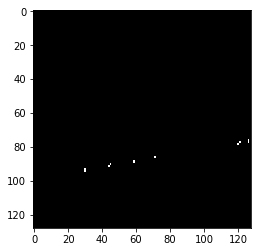

In [224]:
both = data + proj_t[17,40]
plt.imshow((both > 1.1).astype(int), cmap=plt.cm.gray);

The intensity of an x-ray at angle 17, location 40 passing through the data:

In [225]:
np.resize(proj, (l//7,l))[17,40]

6.4384498372605989

The intensity of an x-ray at angle 3, location 14 passing through the data:

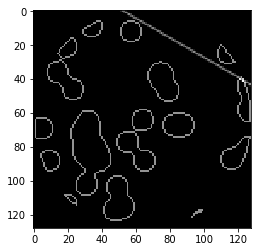

In [226]:
plt.imshow(data + proj_t[3,14], cmap=plt.cm.gray);

Where they intersect:

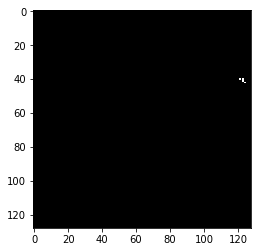

In [227]:
both = data + proj_t[3,14]
plt.imshow((both > 1.1).astype(int), cmap=plt.cm.gray);

The measurement from the CT scan would be a small number here:

In [228]:
np.resize(proj, (l//7,l))[3,14]

2.1374953737965541

In [229]:
proj += 0.15 * np.random.randn(*proj.shape)

#### About *args

In [230]:
a = [1,2,3]
b= [4,5,6]

In [231]:
c = list(zip(a, b))

In [232]:
c

[(1, 4), (2, 5), (3, 6)]

In [233]:
list(zip(*c))

[(1, 2, 3), (4, 5, 6)]

### The Projection (CT readings)

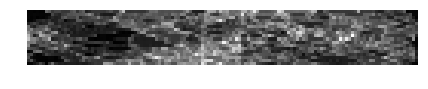

In [234]:
plt.figure(figsize=(7,7))
plt.imshow(np.resize(proj, (l//7,l)), cmap='gray')
plt.axis('off')
plt.savefig("images/proj.png")

## Regresssion

Now we will try to recover the data just from the projections (the measurements of the CT scan)

#### Linear Regression: $Ax = b$

Our matrix $A$ is the projection operator.  This was our 4d matrix above (angle, location, x, y) of the different x-rays:

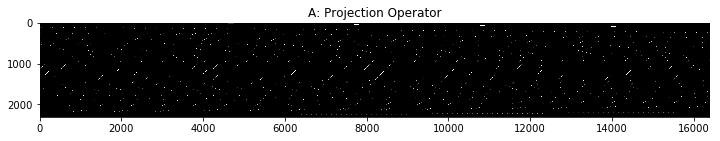

In [203]:
plt.figure(figsize=(12,12))
plt.title("A: Projection Operator")
plt.imshow(proj_operator.todense().A, cmap='gray')

We are solving for $x$, the original data.  We (un)ravel the 2D data into a single column.

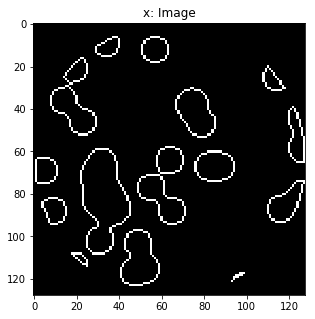

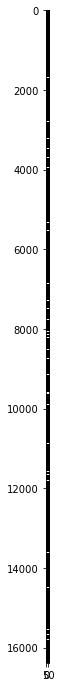

In [202]:
plt.figure(figsize=(5,5))
plt.title("x: Image")
plt.imshow(data, cmap='gray')

plt.figure(figsize=(4,12))
# I am tiling the column so that it's easier to see
plt.imshow(np.tile(data.ravel(), (80,1)).T, cmap='gray')

Our vector $b$ is the (un)raveled matrix of measurements: 

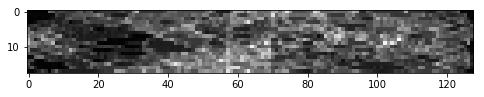

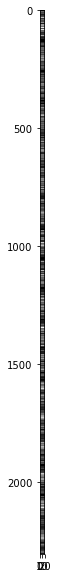

In [238]:
plt.figure(figsize=(8,8))
plt.imshow(np.resize(proj, (l//7,l)), cmap='gray')

plt.figure(figsize=(10,10))
plt.imshow(np.tile(proj.ravel(), (20,1)).T, cmap='gray')

#### Scikit Learn Linear Regression

In [84]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

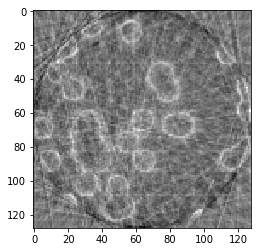

In [126]:
# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)
plt.imshow(rec_l2, cmap='gray')

In [179]:
18*128

2304

In [ ]:
18 x 128 x 128 x 128

In [178]:
proj_operator.shape

(2304, 16384)

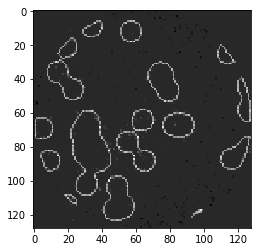

In [87]:
# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)
plt.imshow(rec_l1, cmap='gray')

The L1 penalty works significantly better than the L2 penalty here!